# Final Project - Unsupervised Learning

For my final project, I decided to use a Kaggle data set "Women's E-Commerce Clothing Reviews" which is a real world data set which has been anonymized, including replacing references to the company name with the term "retailer". (https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)

My primary question is a clustering question.  Each row in the data set includes, in addition to other data, a unique 'Clothing ID' and a rating for that item on a scale of 1 to 5, with 5 being the best.  For each clothing item, I am going to tally the number of ratings at each of the levels 1 to 5.  For example, if item A has only been rated as a 5 and has been rated ten times, it would have a rating pattern of [0,0,0,0,10], where if item B has been rated as a 1 three times and a 4 six times, it would have a rating pattern of [3,0,0,6,0].  I am going to look for clusters within the rating patterns with the hopes of using that information to answer other questions about the data.   

This project is available on GitHub at https://github.com/MathDrE/Unsupervised_Final_Project

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

# For text cleaning/preprocessing
import string, re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

# For clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN

# For Nonnegative Matrix Factorization
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix, csr_matrix

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Importing Data and Initial EDA

In [2]:
# Import data
df_0 = pd.read_csv('data/Womens_Clothing_Reviews.csv')

# Column names and basic statistics
print(df_0.columns)
print(df_0.describe())

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')
         Unnamed: 0   Clothing ID           Age        Rating  \
count  23486.000000  23486.000000  23486.000000  23486.000000   
mean   11742.500000    918.118709     43.198544      4.196032   
std     6779.968547    203.298980     12.279544      1.110031   
min        0.000000      0.000000     18.000000      1.000000   
25%     5871.250000    861.000000     34.000000      4.000000   
50%    11742.500000    936.000000     41.000000      5.000000   
75%    17613.750000   1078.000000     52.000000      5.000000   
max    23485.000000   1205.000000     99.000000      5.000000   

       Recommended IND  Positive Feedback Count  
count     23486.000000             23486.000000  
mean          0.822362                 2.535936  
std           0.382216                 5.702202  
min 

 With this, I can see that all the columns with numerical data are not missing any values.  Next I look at the non-numerical columns.

In [3]:
# Looking for NaN entries in data
print('Titles missing', df_0['Title'].isna().sum())
print('Reviews missing', df_0['Review Text'].isna().sum())
print('Division missing', df_0['Division Name'].isna().sum())
print('Department missing', df_0['Department Name'].isna().sum())
print('Class missing', df_0['Class Name'].isna().sum())
df_0.head()

Titles missing 3810
Reviews missing 845
Division missing 14
Department missing 14
Class missing 14


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


The numerical columns have no missing values, but the text columns all have missing values.  Also, it looks like 'Unnamed: 0' is a copy of the indexing column.  I am going to create two sets of the data to facilitate the two unsupervised learning directions I want to explore.  

In [4]:
# Dropping columns with NA values for numeric analysis
df = df_0.drop(columns = ['Unnamed: 0', 
                          #'Clothing ID', 
                          #'Age', 
                          'Title', 
                          'Review Text', 
                          #'Rating',
                          #'Recommended IND', 
                          'Positive Feedback Count', 
                          'Division Name',
                          'Department Name', 
                          'Class Name'
                          ])

df_txt = df_0.drop(columns = ['Unnamed: 0',  
                          'Title', 
                          'Positive Feedback Count', 
                          ]).dropna(ignore_index = True)

print(df.shape, df.columns)
print(df_txt.shape, df_txt.columns)

(23486, 4) Index(['Clothing ID', 'Age', 'Rating', 'Recommended IND'], dtype='object')
(22628, 8) Index(['Clothing ID', 'Age', 'Review Text', 'Rating', 'Recommended IND',
       'Division Name', 'Department Name', 'Class Name'],
      dtype='object')


So now we have two versions of the data, both of which do not have any NA values.  The first has 23486 rows and 4 columns, consisting of the numeric entries for all data points.  The second has only 22628 rows, with most of the dropped rows missing a 'Review Text' entry, but includes more columns, including those with text entries.

At this stage, it is typical to clean the text, but the scikit-learn implementations 'CountVectorizer' and 'TfidfVectorizer' treat all words as lower case and ignore punctuation by default.  I did some experimentation and setting min_df=2 appears to eliminates unique typos, which are common in real world reviews, and is the extent of text 'cleaning' that I am going to do for this analysis. 

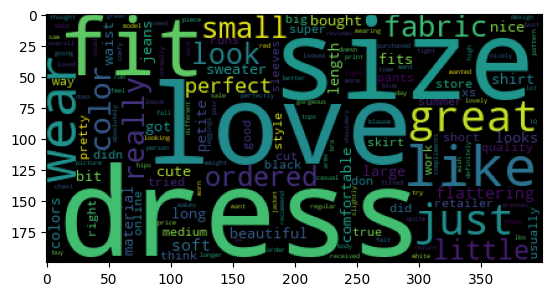

In [5]:
# Finding the words in the text and their frequency
vectorizer_ct = CountVectorizer(min_df = 2, stop_words='english')
X = vectorizer_ct.fit_transform(df_txt['Review Text'])
word_counts = np.sum(X.toarray(), axis=0)
word_freq = dict(zip(vectorizer_ct.get_feature_names_out(), word_counts))

# Creating a plotting a wordcloud based on frequencies
wc = WordCloud().generate_from_frequencies(word_freq)
plt.imshow(wc)

We are going to be using rating data initially, so it is worth looking at the distribution of ratings as well as part of the EDA.

5


C:\Users\eltur\AppData\Local\Temp\ipykernel_14564\1002502704.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),


,Rating,count
0,5,13131
1,4,5077
2,3,2871
3,2,1565
4,1,842


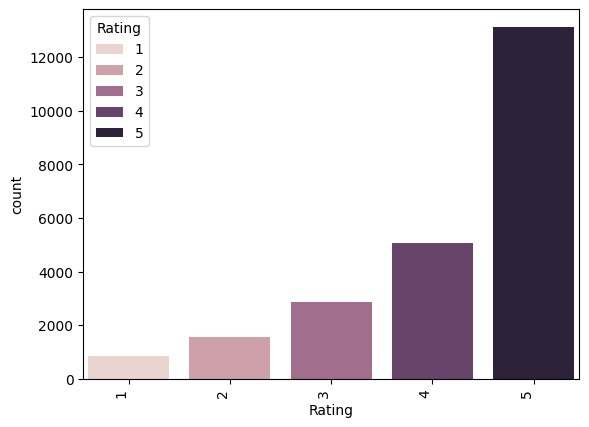

In [6]:
freq_df = pd.DataFrame(df['Rating'].value_counts()).reset_index()
freq_df.columns = ['Rating', 'count']
ncats = len(freq_df)
print(ncats)
ax = sns.barplot(data=freq_df, x='Rating', y='count', hue='Rating')
ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.margins(x=0.01)
freq_df.head()

## Model Building and Training  

The first step is encoding the data for the analysis.

In [7]:
# Extract just the 'Clothing ID' and 'Rating' columns
df_id_rating = df_0.iloc[:,[1,5]]

# Build a data frame with a count of each possible rating for each Clothing ID
counts= df_id_rating.groupby(['Rating']).value_counts()
rating_counts = counts.unstack(fill_value = 0).T
rating_counts

Rating,1,2,3,4,5
Clothing ID,,,,,
0,0,0,0,0,1
1,0,1,0,0,2
2,0,0,0,1,0
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
1201,0,0,1,0,1
1202,0,0,2,2,5
1203,0,0,1,3,7


Here we note that the clothing IDs run from 0 to 1205, inclusive, which was probably done as part of the process of anonymizing the data, so in the analysis, index will be 'Clothing ID'.  We are going to cluster with KMeans, which is sensitive to metric and scaling, so we will standardize this data before clustering.

In [8]:
# Turning the dataframe into an array and standardizing rows
rating_std = np.array(rating_counts)
rating_std = rating_std/np.linalg.norm(rating_std, axis = -1)[:, np.newaxis]

rating_std

array([[0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.4472136 , 0.        , 0.        , 0.89442719],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       ...,
       [0.        , 0.        , 0.13018891, 0.39056673, 0.91132238],
       [0.        , 0.        , 0.        , 0.70710678, 0.70710678],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

We are ready to run a clustering algorithm on the data.  I am going to start with 5 clusters.

In [ ]:
# Our first model, 
KME = KMeans(n_clusters=5, max_iter = 300, random_state=2025, n_init=30)
# Random_state fixes the cluster labels for the analysis description
KMM = KME.fit_predict(rating_std)
print(np.unique_counts(KMM))

# Locations of centroids of clusters
KME.cluster_centers_

UniqueCountsResult(values=array([0, 1, 2, 3, 4], dtype=int32), counts=array([ 69, 316, 133, 528, 160]))


array([[0.39722156, 0.59350009, 0.06789644, 0.03589651, 0.13071486],
       [0.05851954, 0.10748695, 0.17412627, 0.47507262, 0.79919014],
       [0.01918746, 0.05257902, 0.87067408, 0.08727095, 0.18969518],
       [0.01821616, 0.02067272, 0.0395877 , 0.03361822, 0.98114305],
       [0.03036703, 0.03888069, 0.02247173, 0.96216255, 0.05421639]])

The array above gives the centroids of the clusters produced by the algorithm.  In the first row, we see a centroid where most reviews are 1 or 2, I'm going to temporarily refer to this cluster as (1,2).  For the second row, there is a high number of 4 and 5 ratings, with only a few outlying ratings, a cluster I'll refer to as (4,5).  The remaining clusters I'll call (3), (5) and (4) respectively.  

However, there is no reason why there should be 5 types of clusters. We can look at an elbow plot of number of clusters versus intertia to see where the elbow is in the plot. 

In [10]:
def optimize_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1,max_k):
        kmeans = KMeans(n_clusters = k, random_state=2025, n_init=30)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize = (6,9))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()


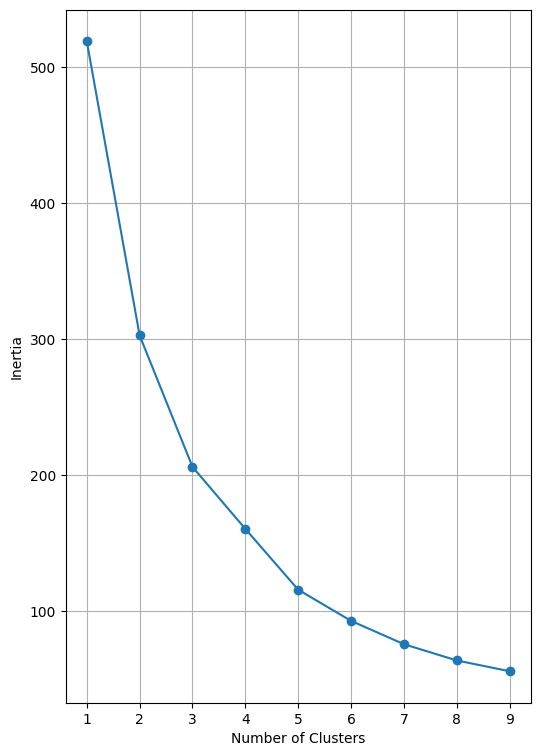

In [11]:
optimize_k_means(rating_std, 10)

There isn't much of an elbow, but the sharpest elbow (or change in slope) occurs for n=5 clusters, so I'm going to proceed with n=5.

Although it is not included in this final report, I did try various pre-processing options, including having vector weights add to 0, standardizing to a mean of 0, only using objects with at least 3 reviews, etc., I compared the silhouette scores of those models, and the preprocessing shown here had the best silhouette score.  I also tried agglomerative clustering and dbscan from scikit-learn and was unable to improve on these results using those methods.

So I am going to proceed with analyzing the clusters from the model above with n=5 clusters.  We see that 'KMM' tells us which cluster each 'Clothing ID' was assigned to.   

In [ ]:
# Cluster assignment for each clothing ID
print(KMM)

# Locations of centroids of each cluster (again)
KME.cluster_centers_

[3 3 4 ... 1 1 3]


array([[0.39722156, 0.59350009, 0.06789644, 0.03589651, 0.13071486],
       [0.05851954, 0.10748695, 0.17412627, 0.47507262, 0.79919014],
       [0.01918746, 0.05257902, 0.87067408, 0.08727095, 0.18969518],
       [0.01821616, 0.02067272, 0.0395877 , 0.03361822, 0.98114305],
       [0.03036703, 0.03888069, 0.02247173, 0.96216255, 0.05421639]])

We have clusters which I have labeled, in order for lowest to highest ratings types, as (1,2), (3), (4), (4,5), (5) and which correspond to predictions of 0, 2, 4, 1, 3 respectively. I am going to think of those, using American grading scales, as F, D, C, B, A and adjust the predictions accordingly.

In [13]:
grading_dict = {0:'F', 1:'B', 2:'D', 3:'A', 4:'C'}
grades = [grading_dict[i] for i in KMM]
print(grades)

['A', 'A', 'C', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'F', 'A', 'C', 'A', 'F', 'A', 'A', 'F', 'C', 'C', 'A', 'A', 'A', 'A', 'A', 'C', 'A', 'A', 'A', 'C', 'A', 'C', 'C', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'A', 'C', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'B', 'D', 'D', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'A', 'A', 'A', 'C', 'A', 'F', 'A', 'D', 'A', 'C', 'A', 'C', 'D', 'C', 'C', 'A', 'F', 'A', 'C', 'D', 'D', 'F', 'C', 'A', 'F', 'C', 'A', 'A', 'C', 'F', 'A', 'F', 'A', 'A', 'A', 'D', 'A', 'B', 'C', 'D', 'D', 'B', 'B', 'F', 'B', 'A', 'B', 'A', 'A', 'B', 'C', 'C', 'B', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'A', 'D', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'A', 'C', 'A', 'D', 'C', 'B', 'A', 'B', 'A', 'D', 'A', 'A', 'B', 'A', 'C', 'D', 'A', 'A', 'C', 'A', 'C', 'A', 'A', 'A', 'D', 'D', 'B', 'A', 'D', 'D', 'A', 'A', 'A', 'F', 'A', 'F', 'A', 'C', 'A', 'A', 'A', 'D', 'F', 'A', 'B', 'A', 'A', 'D', 'D', 'A',

The strength and weakness of unsupervised learning is that it finds underlying patterns that aren't obvious to us, but we would still like to use these results to better understand the data set.  For example, I find it harder to shop for bottoms than for tops.  Are online shoppers more critical of bottoms than tops in their ratings?  I would like to explore whether certain classes of garments are more likely to fall in one of these rating pattern groups.

In [14]:
# Department categories
print(pd.unique(df_txt['Department Name']))

['Intimate' 'Dresses' 'Bottoms' 'Tops' 'Jackets' 'Trend']


In [33]:
# Finding the clothing ID for tops
tops_id = df_txt['Clothing ID'][df_txt['Department Name']== 'Tops']
tops_id = np.unique(tops_id)

# Finding the clothing ID for dresses
bottoms_id = df_txt['Clothing ID'][df_txt['Department Name']== 'Bottoms']
bottoms_id = np.unique(bottoms_id)

# Finding the clothing ID for bottoms
dresses_id = df_txt['Clothing ID'][df_txt['Department Name']== 'Dresses']
dresses_id = np.unique(dresses_id)
# Finding a count of letter grades for the three departments
tops_predictions = [grades[i] for i in tops_id]
print('Tops', np.unique(tops_predictions, return_counts = True))

bottoms_predictions = [grades[i] for i in bottoms_id]
print('Bottoms', np.unique(bottoms_predictions, return_counts = True))

dresses_predictions = [grades[i] for i in dresses_id]
print('Dresses', np.unique(dresses_predictions, return_counts = True))

Tops (array(['A', 'B', 'C', 'D', 'F'], dtype='<U1'), array([37, 93, 13, 11,  3]))
Bottoms (array(['A', 'B', 'C', 'D', 'F'], dtype='<U1'), array([74, 68, 25, 20,  8]))
Dresses (array(['A', 'B', 'C', 'D', 'F'], dtype='<U1'), array([12, 38,  6,  5,  2]))


Now I'm honestly curious what company this data was taken from.  Recall that an A grade corresponds to the cluster where the majority of ratings is 5, and pants has most the highest percentage of clothing items with that rating pattern.  This really surprises me.

In the interest of keeping this project at a reasonable length, I am leaving out similar analysis related to other categories available in this data, for example, similar code would allow us to investigate whether certain rating patterns were more likely to occur in various age groups.  It could also be interesting to look at the relation between rating patterns and whether a customers recommend a specific clothing item.  

## Switching gears to text analysis

I also did some work with text analysis for this project.  Each row includes a rating from 1 to 5 of the clothing item, but also includes a binary response column for whether they would recommend the item to others.  I was curious whether NMF factorization could help us predict, from the text in the review, whether the reviewer would recommend the item or what rating they would assign to the item.

The two-component model will be used to predict whether the reviewer will recommend the clothing item, and the model with five components will be compared to reviews.

In [36]:
# Build Vectorizer
vectorizer = TfidfVectorizer(min_df = 2, stop_words='english')
vect_matrix = vectorizer.fit_transform(df_txt['Review Text'])

# two component model
MF_two = NMF(n_components= 2)
factorization_two = MF_two.fit_transform(vect_matrix)

# five component model
MF_five = NMF(n_components = 5)
factorization_five = MF_five.fit_transform(vect_matrix)

# sizes of NMF
print(factorization_two.shape)
print(factorization_five.shape)

(22628, 2)
(22628, 5)


Now I am going to assign each test review to the largest coefficient in the NMF.

In [19]:
# Initial predictions are the column index with the highest entry
predictions_two = np.argmax(factorization_two, axis = 1)
predictions_five = np.argmax(factorization_five, axis = 1)
print(predictions_two)
print(predictions_five)

[1 1 0 ... 0 1 1]
[2 3 0 ... 3 1 1]


Below, we see that the predictions from the two-component model does a poor job of predicting whether an item will be recommended or not.  The matrix factorization is finding different latent factors than whether the reviewer would recommend the item.

In [37]:
acc = np.sum(df_txt['Recommended IND'] - predictions_two)/len(predictions_two)
print('Accuracy of predicting whether an item is recommended is', acc)

Accuracy of predicting whether an item is recommended is 0.5946172883153615


Below we see that 82% of reviews do recommend the clothing item, so just predicting "always recommend" would be more accurate that using this model.

In [21]:
np.sum(df_txt['Recommended IND'])/len(df_txt['Recommended IND'])

np.float64(0.8187643627364327)

Below, I am calculating how well the five component model predicts rating (from 1 to 5).

In [ ]:
def numeric_to_labels(y_pred, print_matrix = False):
    P = np.array(range(1,6))
    
    # Building a data frame with predictions and true values from the training data
    Y= pd.DataFrame(df_txt['Rating'], columns = ['Rating'])
    Y['Predicted'] = y_pred

    # Count predicted (numeric) labels for each label (training predictions)
    Z = np.zeros((5,5))
    grouped = Y.groupby(['Rating'])
    for l in range(5):
        just_l = grouped.get_group(P[l])
        unique, counts = np.unique(just_l['Predicted'], return_counts=True)
        for i in range(len(unique)):
            Z[l][unique[i]] = counts[i]
    if print_matrix:
        print(Z)

    # Matching integer label and true labels
    best = 0
    A = set(range(5))
    for i in A:
        R = A.difference({i})
        for j in R:
            S = R.difference({j})
            for k in S:
                T = S.difference({k})
                for l in T:
                    U = T.difference({l})
                    m = U.pop()
                    correct_count = Z[0][i] + Z[1][j] + Z[2][k] + Z[3][l] + Z[4][m]
                    if correct_count > best:
                        best = correct_count
                        labelorder = (i,j,k,l,m)
    
    # Calculate accuracy on training data
    acc =best/len(Y['Predicted'])

    # Using the reordering information to create a dictionary
    cat_labels = dict(zip(labelorder, P))

    return cat_labels, acc

In [ ]:
category_labels, accuracy = numeric_to_labels(predictions_five, print_matrix=True)
print('Training Accuracy:', accuracy)

[[  77.  127.   54.  479.   84.]
 [ 166.  214.   81.  940.  148.]
 [ 394.  394.  182. 1618.  235.]
 [ 844.  707.  908. 2098.  351.]
 [1713. 2025. 4725. 3247.  817.]]
{4: np.int64(1), 1: np.int64(2), 0: np.int64(3), 3: np.int64(4), 2: np.int64(5)}
Training Accuracy: 0.3321106593600848


C:\Users\eltur\AppData\Local\Temp\ipykernel_14564\2759314936.py:10: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  just_l = grouped.get_group(P[l])


This model also has poor accuracy.  The latent factors that the model is finding are not directly related to the ratings that the users are giving.  It would be interesting to see what latent factors the matrix factorization is finding, but that is a question for another day.

## Discussion/Conclusion

In this project, we used clustering on review patterns to see what review patterns were most common and to see how those clusters related to other data values in the dataset.  This was mostly successful.
I also tried to find a relationship between reviews and ratings, or between reviews and whether a reviewer would recommend an article of clothing.  This was less successful.  The NMF is finding underlying factors in the text, but they are not obviously related to ratings or whether an item of clothing would be recommended.  It would be interesting in the future to see what latent factors are being caught by the NMF.

I struggled with this project.  I am not happy with the results that I got, but realized the weaknesses of the analysis when it was too late for me to change directions.  Because I clustered on clothing items and did text analysis by data point, there was no obvious way to connect those two results, which was my initial intent.  I left out the sentiment analysis I did for the same reason.  However, I think the question I started with is still interesting and was happy that I was able to get some results on that question.